# Missing data imputation using optimal transport

In this notebook, we will show how to use optimal transport to impute missing values in an incomplete dataset.

The methods we will use are described in the following paper:

B. Muzellec, J. Josse, C. Boyer, M. Cuturi, [Missing Data Imputation using Optimal Transport](https://arxiv.org/pdf/2002.03860.pdf).

## Imports and installs

In [1]:
# Ignore this cell if the corresponding packages are already installed

!pip install pot
!pip install geomloss

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

import os

from geomloss import SamplesLoss

from imputers import OTimputer, RRimputer

from utils import *
from data_loaders import dataset_loader
from softimpute import softimpute, cv_softimpute

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')
import pdb

## Data loading

The dataset loader utilities assume there is a "datasets/" folder in the current directory.

In [3]:
if not os.path.isdir("datasets"):
    os.mkdir("datasets")

Load the data and whiten it.
In a real missing data situation, the mean and std would have to be estimated on non-missing data.

In [ ]:
# ground_truth = scale(dataset_loader("wine")) # "wine" can be replaced with any of the datasets
#                                              # supported by dataset_loader (see data_loaders.py)
# X_true = torch.from_numpy(ground_truth)

In [5]:
from datasets import load_dataset
train_cali, test_cali = load_dataset("california")
train_cali, test_cali = scale(train_cali), scale(test_cali)

#TODO: override
ground_truth = train_cali
gt_test_cali = test_cali
train_cali, test_cali = torch.from_numpy(train_cali).double(), torch.from_numpy(test_cali).double()
X_true = train_cali
train_cali.shape, test_cali.shape

/Users/liancheng/miniconda3/envs/bmdp/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/liancheng/miniconda3/envs/bmdp/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/Users/liancheng/miniconda3/envs/bmdp/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/liancheng/miniconda3/envs/bmdp/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were

(torch.Size([18389, 9]), torch.Size([2044, 9]))

## Missing data generation

Let's now simulate missing data. We will assume that the data is missing completely at random (MCAR) with a 50% probability.
Additional MAR and MNAR missing data mechanisms are available in utils.py.

In [6]:
np.random.seed(42)

p = 0.5

mask = np.random.rand(*ground_truth.shape) < p #True for missing values, false for others
x_miss = np.copy(ground_truth)

x_miss[mask] = np.nan
X_miss = torch.from_numpy(x_miss).double()
X_miss.shape

torch.Size([18389, 9])

## Hyperparameters

In [7]:
n, d = X_miss.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon = pick_epsilon(X_miss) # Set the regularization parameter as a multiple of the median distance, as per the paper.

## Sinkhorn imputation (Algorithm 1)

In [8]:
sk_imputer = OTimputer(eps=epsilon, batchsize=batchsize, lr=lr, niter=8000)

In [9]:
sk_imp, sk_maes, sk_rmses = sk_imputer.fit_transform(X_miss, verbose=True, report_interval=500, X_true=X_true)

INFO:root:batchsize = 128, epsilon = 0.1400
INFO:root:Iteration 0:	 Loss: 1.2218	 Validation MAE: 0.7544	RMSE: 1.0121
INFO:root:Iteration 500:	 Loss: 1.1335	 Validation MAE: 0.6903	RMSE: 0.9575
INFO:root:Iteration 1000:	 Loss: 1.0924	 Validation MAE: 0.6390	RMSE: 0.9161
INFO:root:Iteration 1500:	 Loss: 0.8604	 Validation MAE: 0.6000	RMSE: 0.8852
INFO:root:Iteration 2000:	 Loss: 0.7118	 Validation MAE: 0.5712	RMSE: 0.8632
INFO:root:Iteration 2500:	 Loss: 0.8255	 Validation MAE: 0.5518	RMSE: 0.8476
INFO:root:Iteration 3000:	 Loss: 1.1850	 Validation MAE: 0.5375	RMSE: 0.8363
INFO:root:Iteration 3500:	 Loss: 0.9760	 Validation MAE: 0.5274	RMSE: 0.8287
INFO:root:Iteration 4000:	 Loss: 0.7985	 Validation MAE: 0.5200	RMSE: 0.8229
INFO:root:Iteration 4500:	 Loss: 0.9331	 Validation MAE: 0.5152	RMSE: 0.8183
INFO:root:Iteration 5000:	 Loss: 0.7509	 Validation MAE: 0.5128	RMSE: 0.8150
INFO:root:Iteration 5500:	 Loss: 0.9115	 Validation MAE: 0.5102	RMSE: 0.8134
INFO:root:Iteration 6000:	 Loss: 0.8

In [10]:
sk_imp.shape, sk_maes.shape, sk_rmses.shape

(torch.Size([18389, 9]), (8000,), (8000,))

## Round-robin imputation (Algorithm 3)

Round-robin imputation models iteratively impute each variable using all the other variables.
The imputation is performed according to an optimal transport criterion, as in Algorithm 3 in the paper.
Any model can be used to perform the variable imputation. It is even possible to specify one type of model per variable
(e.g. predict a variable with a linear model, and an other with an MLP), as long as those models gave trainable parameters.

We give here two examples. In the first, variables are predicted using linear models, and in the second using a MLP.

Note that even if each variable has an associated model of the same type as the others,
those models have distinct sets of parameters.

### Linear round-robin

In [11]:
#Create the imputation models
d_ = d - 1
models = {}

for i in range(d):
    models[i] = nn.Linear(d_, 1)

#Create the imputer
lin_rr_imputer = RRimputer(models, eps=epsilon, lr=lr)

In [12]:
lin_imp, lin_maes, lin_rmses = lin_rr_imputer.fit_transform(X_miss, verbose=True, X_true=X_true)
lin_imp.shape, lin_maes.shape

INFO:root:Iteration 0:	 Loss: 1.2170	Validation MAE: 0.6876	RMSE:  0.9278
INFO:root:Iteration 1:	 Loss: 1.0191	Validation MAE: 0.5907	RMSE:  0.8226
INFO:root:Iteration 2:	 Loss: 1.5371	Validation MAE: 0.5482	RMSE:  0.7764
INFO:root:Iteration 3:	 Loss: 1.0635	Validation MAE: 0.5265	RMSE:  0.7620
INFO:root:Iteration 4:	 Loss: 0.9696	Validation MAE: 0.5112	RMSE:  0.7555
INFO:root:Iteration 5:	 Loss: 0.8931	Validation MAE: 0.5040	RMSE:  0.7533
INFO:root:Iteration 6:	 Loss: 1.1505	Validation MAE: 0.4994	RMSE:  0.7516
INFO:root:Iteration 7:	 Loss: 0.9680	Validation MAE: 0.4975	RMSE:  0.7495
INFO:root:Iteration 8:	 Loss: 1.2693	Validation MAE: 0.4986	RMSE:  0.7516
INFO:root:Iteration 9:	 Loss: 1.2204	Validation MAE: 0.4981	RMSE:  0.7503
INFO:root:Early stopping criterion not reached


(torch.Size([18389, 9]), (10,))

### MLP round-robin

In [13]:
#Create the imputation models
d_ = d - 1
models = {}

for i in range(d):
    models[i] = nn.Sequential(nn.Linear(d_, 2 * d_),
                              nn.ReLU(),
                              nn.Linear(2 * d_, d_),
                              nn.ReLU(),
                              nn.Linear(d_, 1))

#Create the imputer
mlp_rr_imputer = RRimputer(models, eps=epsilon, lr=lr)

In [14]:
mlp_imp, mlp_maes, mlp_rmses = mlp_rr_imputer.fit_transform(X_miss, verbose=True, X_true=X_true)

INFO:root:Iteration 0:	 Loss: 1.0206	Validation MAE: 0.5956	RMSE:  0.8438
INFO:root:Iteration 1:	 Loss: 1.0809	Validation MAE: 0.5333	RMSE:  0.7808
INFO:root:Iteration 2:	 Loss: 0.9568	Validation MAE: 0.5195	RMSE:  0.7750
INFO:root:Iteration 3:	 Loss: 0.8363	Validation MAE: 0.5147	RMSE:  0.7928
INFO:root:Iteration 4:	 Loss: 0.8296	Validation MAE: 0.5100	RMSE:  0.7960
INFO:root:Iteration 5:	 Loss: 1.0631	Validation MAE: 0.5108	RMSE:  0.8022
INFO:root:Iteration 6:	 Loss: 0.9887	Validation MAE: 0.5098	RMSE:  0.8039
INFO:root:Iteration 7:	 Loss: 0.9351	Validation MAE: 0.5081	RMSE:  0.8048
INFO:root:Iteration 8:	 Loss: 0.9788	Validation MAE: 0.5104	RMSE:  0.8144
INFO:root:Iteration 9:	 Loss: 0.9593	Validation MAE: 0.5118	RMSE:  0.8149
INFO:root:Early stopping criterion not reached


## Baselines

Let's compare OT imputations to some baselines. As in the paper, we consider the following baselines: (i) mean imputation, (ii) iterated conditional ridge regression and (iii) softimpute.

In [15]:
# Imputation by the means
simp_imputer = SimpleImputer()
mean_imp = simp_imputer.fit_transform(x_miss)
mean_mae = MAE(mean_imp, ground_truth, mask)
mean_rmse = RMSE(mean_imp, ground_truth, mask)
print(mean_imp.shape, ground_truth.shape, mask.shape)

# ICE
ice_imputer = IterativeImputer(random_state=0, max_iter=50)
ice_imp = ice_imputer.fit_transform(x_miss)
ice_mae = MAE(ice_imp, ground_truth, mask)
ice_rmse = RMSE(ice_imp, ground_truth, mask)

# Softimpute
cv_error, grid_lambda = cv_softimpute(x_miss, grid_len=15)
lbda = grid_lambda[np.argmin(cv_error)]
soft_imp = softimpute((x_miss), lbda)[1]

soft_mae = MAE(soft_imp, ground_truth, mask)
soft_rmse = RMSE(soft_imp, ground_truth, mask)

(18389, 9) (18389, 9) (18389, 9)


/Users/liancheng/miniconda3/envs/bmdp/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## Comparison plots

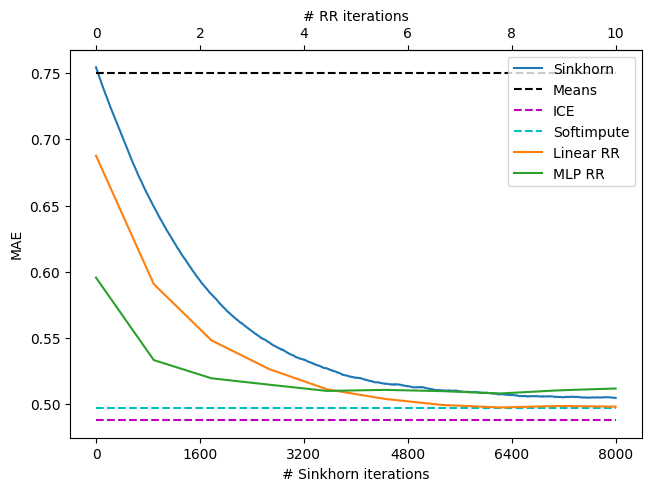

In [16]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

secax = ax.secondary_xaxis('top', functions=(lambda x: x * len(lin_maes) / npoints, lambda x: x * npoints / len(lin_maes)))
secax.set_xlabel('# RR iterations')

ax.plot(np.linspace(0, 1, len(lin_maes)) * npoints, lin_maes, label='Linear RR')
ax.plot(np.linspace(0, 1, len(mlp_maes)) * npoints, mlp_maes, label='MLP RR')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

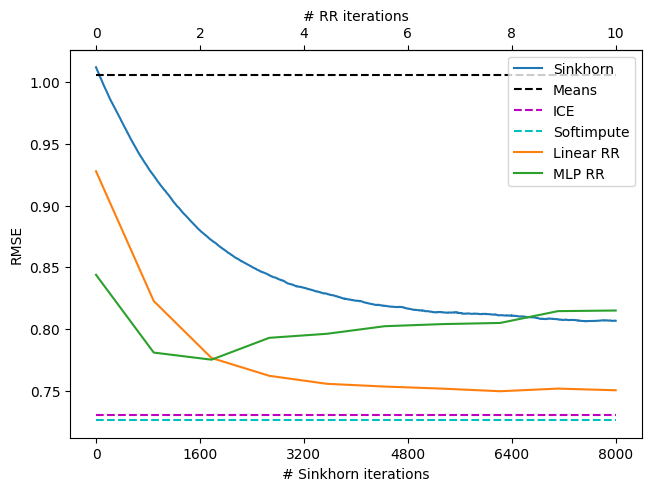

In [17]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

secax = ax.secondary_xaxis('top', functions=(lambda x: x * len(lin_maes) / npoints, lambda x: x * npoints/ len(lin_maes)))
secax.set_xlabel('# RR iterations')

ax.plot(np.linspace(0, 1, len(lin_rmses)) * npoints, lin_rmses, label='Linear RR')
ax.plot(np.linspace(0, 1, len(mlp_maes)) * npoints, mlp_rmses, label='MLP RR')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

In [18]:
## Out of sample result for Linear RR and MLP RR (Alg3)

In [19]:
np.random.seed(42)

p = 0.5

mask = np.random.rand(*test_cali.shape) < p #True for missing values, false for others
print(mask.shape)
test_cali_miss = np.copy(test_cali)
print(test_cali_miss.shape)

test_cali_miss[mask] = np.nan
test_cali_miss = torch.from_numpy(test_cali_miss).double()
test_cali_miss.shape

np_mask = mask
mask = torch.from_numpy(mask)

(2044, 9)
(2044, 9)


In [27]:
#for linear RR
lin_imp, lin_mae, lin_rmse = lin_rr_imputer.transform(test_cali_miss, mask=mask, verbose=True, X_true=test_cali) 

#for MLP RR
mlp_imp, mlp_mae, mlp_rmse = mlp_rr_imputer.transform(test_cali_miss, mask=mask, verbose=True, X_true=test_cali)

INFO:root:Iteration 0:	 Validation MAE: 0.5104	RMSE: 0.7288
INFO:root:Iteration 1:	 Validation MAE: 0.4882	RMSE: 0.7071
INFO:root:Iteration 2:	 Validation MAE: 0.4839	RMSE: 0.7067
INFO:root:Iteration 3:	 Validation MAE: 0.4838	RMSE: 0.7096
INFO:root:Iteration 4:	 Validation MAE: 0.4861	RMSE: 0.7147
INFO:root:Iteration 5:	 Validation MAE: 0.4886	RMSE: 0.7206
INFO:root:Iteration 6:	 Validation MAE: 0.4911	RMSE: 0.7250
INFO:root:Iteration 7:	 Validation MAE: 0.4951	RMSE: 0.7325
INFO:root:Iteration 8:	 Validation MAE: 0.4980	RMSE: 0.7378
INFO:root:Iteration 9:	 Validation MAE: 0.5015	RMSE: 0.7441
INFO:root:Early stopping criterion not reached
INFO:root:Iteration 0:	 Validation MAE: 0.5053	RMSE: 0.7462
INFO:root:Iteration 1:	 Validation MAE: 0.4794	RMSE: 0.7299
INFO:root:Iteration 2:	 Validation MAE: 0.4742	RMSE: 0.7375
INFO:root:Iteration 3:	 Validation MAE: 0.4747	RMSE: 0.7451
INFO:root:Iteration 4:	 Validation MAE: 0.4767	RMSE: 0.7510
INFO:root:Iteration 5:	 Validation MAE: 0.4796	RMSE: 

In [28]:
# Imputation by the means
mean_imp = simp_imputer.transform(test_cali_miss)
mean_mae = MAE(mean_imp, gt_test_cali, np_mask)
mean_rmse = RMSE(mean_imp, gt_test_cali, np_mask)

# ICE
ice_imp = ice_imputer.transform(test_cali_miss)
ice_mae = MAE(ice_imp, gt_test_cali, np_mask)
ice_rmse = RMSE(ice_imp, gt_test_cali, np_mask)

In [29]:
print(f'lin RR out of sample MAE:{lin_mae}')
print(f'mlp RR out of sample MAE:{mlp_mae}')
print(f'mean out of sample MAE:{mean_mae}')
print(f'ice out of sample MAE:{ice_mae}')

print(f'lin RR out of sample RMSE:{lin_rmse}')
print(f'mlp RR out of sample RMSE:{mlp_rmse}')
print(f'mean out of sample RMSE:{mean_rmse}')
print(f'ice out of sample RMSE:{ice_rmse}')

lin RR out of sample MAE:0.5015038240014207
mlp RR out of sample MAE:0.4856911253014401
mean out of sample MAE:0.7342482301069667
ice out of sample MAE:0.7342482301069667
lin RR out of sample RMSE:0.7440975966124938
mlp RR out of sample RMSE:0.7686255243711017
mean out of sample RMSE:0.9814992069695488
ice out of sample RMSE:0.9814992069695488
